## Installations and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!sudo add-apt-repository -y ppa:openjdk-r/ppa
!sudo apt-get purge openjdk-*
!sudo apt-get install openjdk-8-jdk
!sudo apt-get install xvfb xserver-xephyr vnc4server python-opengl ffmpeg

In [ ]:
%%capture
!pip install --upgrade 'setuptools==57.5.0'
!pip install 'gym==0.19.0'
!pip install --upgrade wheel==0.38.4

In [ ]:
%%capture
!pip install --upgrade 'minerl==0.4.4'
!pip install pyvirtualdisplay

!pip install scikit-learn
!pip install -U colabgymrender

In [ ]:
%%capture
!apt-get install xorg openbox
!apt-get install xvfb

In [ ]:
import random
import numpy as np
import pandas as pd
import torch as th
from torch import nn
import gym
import minerl
import torch
from tqdm.notebook import tqdm
from colabgymrender.recorder import Recorder
from pyvirtualdisplay import Display
from sklearn.cluster import KMeans
import logging
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import json
from time import time
import pickle

logging.disable(logging.ERROR) # reduce clutter, remove if something doesn't work to see the error logs.

/usr/local/lib/python3.10/dist-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [ ]:
minerl.data.download(directory='data', environment='MineRLObtainIronPickaxe-v0');

Download: https://minerl.s3.amazonaws.com/v4/MineRLObtainIronPickaxe-v0.tar: 100%|██████████| 2802.0/2801.89952 [03:07<00:00, 14.93MB/s]


In [ ]:
data=minerl.data.make("MineRLObtainIronPickaxe-v0")

In [ ]:
# run only once!!!
display = Display(visible=0, size=(400, 300))
display.start();

## Load Preprocessed Data

In [ ]:
with open('/content/drive/MyDrive/minecraft proj/state_to_transition.json', 'r') as f: #change paths to your own
   state_to_actions_without_clustering = json.load(f)

with open('/content/drive/MyDrive/minecraft proj/pov_cluster_to_transition_with_30K_pov.json', 'r') as f:
    pov_to_actions = json.load(f)

In [ ]:
def load_pov_clustering(model_fn):
    """
    Loads the pov clustering model
    
    Args:
        model_fn: file name of the stored model
    """
    clustering = pickle.load(open(model_fn, "rb"))
    return clustering

In [ ]:
!unzip '/content/drive/MyDrive/minecraft proj/KNN_povs_30K.zip' 
clustering = load_pov_clustering('KNN_povs.pkl')

Archive:  /content/drive/MyDrive/minecraft proj/KNN_povs_30K.zip
  inflating: KNN_povs.pkl            


## Learned-Actions Algorithm

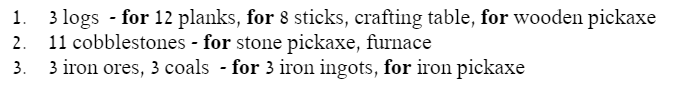

In [ ]:
def update_stage(state, stage):
  """Check the inventory and updates the agent's stage in the game
  
  Args:
      state: the agent's state in the game
      stage: game's stage, derived from agent's inventory

  Return:
      tuple (stage, is_changed)
  """
  if stage == 0:
    logs = int(state['inventory']['log'])
    if logs > 0:
      print("GOT", logs, "logs")
    if logs >= 3:
      return (1, True)
  
  elif stage == 1:
    cobblestones = int(state['inventory']['cobblestone'])
    if logs > 0:
      print("GOT", cobblestones, "cobblestones")
    if cobblestones >= 11:
      return (2, True)
  
  else: # stage == 2:
    iron_ores = int(state['inventory']['iron_ore'])
    coals = int(state['inventory']['coal'])
    if iron_ores >= 3 and coals >= 3:
      return (3, True)
  
  return (stage, False)

In [ ]:
def predict_pov_cluster(model, pov):
    """
    Predict cluster label of a single POV
    
    Args:        
        model: instance of the clustering model
        pov: 64*64*3 array
    """
    # Normalize the new pov
    pov_normalized = pov / 255.0  
    # Predict the label of the new pov
    label = model.predict(pov_normalized.reshape(1, -1))
    return label[0]

In [ ]:
def get_relevant_actions(model, state):
    """
    Returns the relevant actions to the agent based on its pov. If not possible, use the current state including what it is holding in hand and its inventory. 

    Args:
        model: instance of the clustering model
        state: the agent's current state
    Return:
        actions: list of actions 
    """
    # Get the pov cluster by the clustering model
    current_pov = np.array(state['pov'])
    pov_cluster = predict_pov_cluster(model, current_pov)

    # If possible, get the actions by the relevant pov cluster
    pov_cluster_str = str(pov_cluster)
    if pov_cluster_str != '-1' and pov_cluster_str in pov_to_actions:
      actions = pov_to_actions[pov_cluster_str]
      actions = [lst for lst in actions if lst]
      return actions

    # If pov cluster is not valid, get the actions by the current state including what is in hand and the inventory
    state_small = {'equipped_items.mainhand.type': state['equipped_items']['mainhand']['type'], 
                  'inventory': {key:int(val) for key,val in state['inventory'].items()}}
    key_state = json.dumps(state_small)
    actions = state_to_actions_without_clustering.get(key_state, None)

    if actions:
      actions = [lst for lst in actions if lst]

    return actions

## Test

In [ ]:
def str_to_act(action, value, env):
    """Reutrn the action should be done in the expected format"""
    act = env.action_space.noop()
    act[action] = value
    return act

In [ ]:
def act(state, stage, env):
    """Performs a single step for the agent in the game.
    Choose the next action from the distribution of the actions of other agents performed from a state similar to the agent's current state.
    
    Args:
        state: the agent's state in the game
        stage: game's stage, derived from agent's inventory
        env: game environment
    Return:
        (obs, rewards, done, stage, steps): data of next state
    """
    actions = get_relevant_actions(clustering, state)
    
    if actions is None or actions == []:
      action = env.action_space.sample()
      obs, rewards, done, _ = env.step(action) # Take a random action
      steps = 1
      return obs, rewards, done, stage, steps
    
    steps = 0
    rewards = 0
    chosen_action = random.choice(actions) # [[a, 1], [b, 2]]
    for a in chosen_action:
      action, value = tuple(a)
      obs, reward, done, _ = env.step(str_to_act(action, value, env))
      steps += 1
      rewards += reward
      stage, is_changed = update_stage(state, stage)
      if is_changed:
        print(f"stage {stage}")

      if done:
        return obs, rewards, done, stage, steps

    return obs, rewards, done, stage, steps

In [ ]:
def test_model(episodes, env):
  stats = {'runtime': [], 'reward': [], 'reward_at': []}

  for i in range(1, episodes + 1):
    print(f"Episode {i}")
    start = time()
    obs = env.reset()
    done = False
    total_reward = 0
    stage = 0
    total_steps = 0
    reward_at = []
    j = 0
    
    while not done:
      obs, reward, done, stage, steps = act(obs, stage, env)
      total_steps += steps
      total_reward += reward
      if reward > 0:
        reward_at.append((total_steps, reward))
      if total_steps >= 100 * j:
        j += 1
        print(total_steps)
      if done:
        break
    
    stats['runtime'].append(time() - start)
    stats['reward'].append(total_reward)
    stats['reward_at'].append(reward_at)

  return stats

In [ ]:
# deletes virtual display if crashed and restarts it
# display.stop()
# !rm -rf /content/logs
# !rm -rf /content/video

# display = Display(visible=0, size=(400, 300))
# display.start();

In [ ]:
env = gym.make('MineRLObtainIronPickaxe-v0')
env = Recorder(env, './video', fps=60)

In [ ]:
#saving stats
episodes = 2
stats = test_model(episodes, env)
with open(f'stats_learned_actions.json', 'w') as outfile:
    json.dump(stats, outfile)

Episode 1
1
100
200
300
400
500
601
700
800
900
1000
1103
1201
1301
1401
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3001
3100
3200
3300
3401
3500
3600
3700
3800
3900
4001
4100
4200
4302
4400
4500
4600
4700
4800
4900
5001
5100
5200
5300
5400
5500
5600
5700
5800
5900
Episode 2
1
100
200
300
400
500
600
701
